## QUESTION 2 : 5 QUBIT CIRCUITS

**_______________________________________________________________________________________________________________**

### PART 1 : 5 QUBIT CIRCUIT and Z(0)

**_______________________________________________________________________________________________________________**

#### Imports :

In [1]:
# Numpy is used for working with arrays and perform numerical operations
import numpy as np
# Pyplot is used to create graphs
import matplotlib.pyplot as plt
# Plot_histogram is used to visualize the simulation result.
from qiskit.visualization import plot_histogram

# QuantumCircuit is used to create quantum circuits
from qiskit import QuantumCircuit, transpile
# Qiskit_aer library provides backend quantum simulators
from qiskit_aer import Aer

# QiskitRuntimeService class is used to run actual IBM QC hardware
from qiskit_ibm_runtime import QiskitRuntimeService
# SamplerV2 is used to find the probabilities of output states
from qiskit_ibm_runtime import SamplerV2 as Sampler

## Solution to (A) - Input Waveform preparation

#### i) Quantum circuit creation and adding different components:

In [2]:
# Number of qubits 
n_qubits = 5

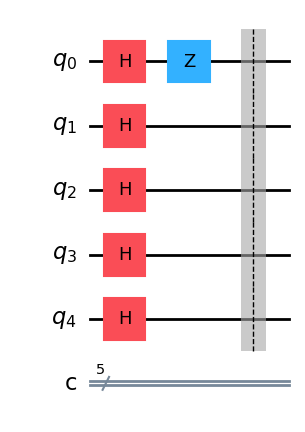

In [3]:
# Creating a Quantum Circuit 
qc = QuantumCircuit(n_qubits,n_qubits)

# Adding H gates
for i in range(n_qubits):
    qc.h(i)

# Applying z gate
qc.z(0)

# Creating barrier
qc.barrier()

# Visualizing the circuit
qc.draw(output='mpl', style='iqp')

***Fig 01 : Quantum circuit with input state***

#### ii) Simulation

In [4]:
# Getting the simulator
simulator = Aer.get_backend("statevector_simulator")

# Transpile transforms the circuit to something appropriate for the machine
sim_circuit = transpile(qc, backend = simulator)

# The run method in the simulator executes the transpiled circuit.
sim_job = simulator.run(sim_circuit, shots = 4096)

# I am fetching the results of the simulation job execution.
sim_result = sim_job.result()

# Getting the statevector
statevector = sim_result.get_statevector()

#### iii) Fetching the amplitudes and plotting histogram :

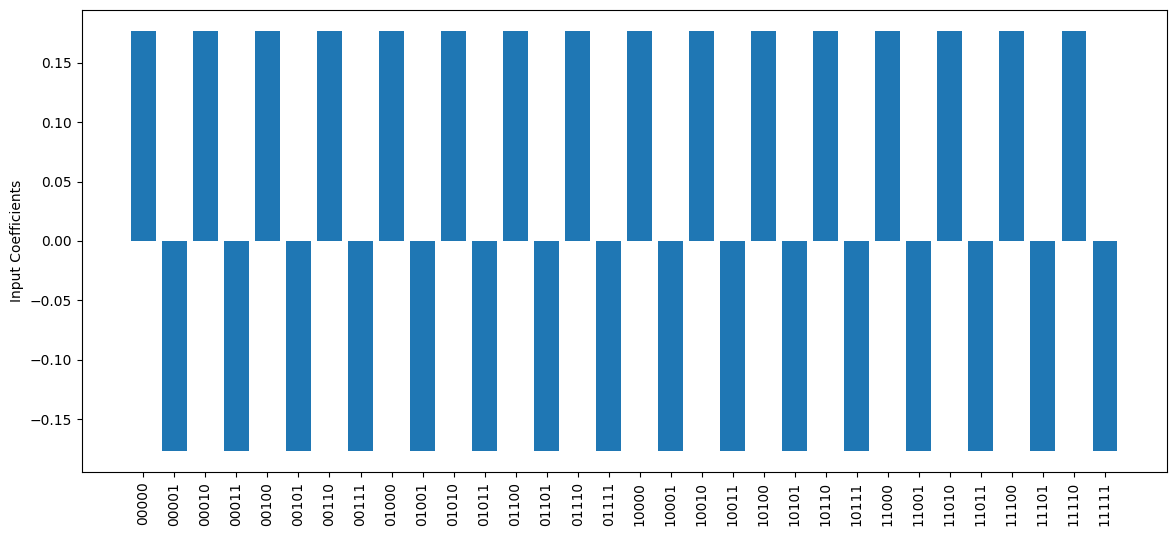

In [5]:
# Getting the amplitudes of statevector
amplitudes = np.real(statevector)   
binaries=[] 

# Generating binary values
for i in range(0,len(amplitudes)): 
    binaries +=['{0:05b}'.format(i)]

# Plotting the input waveform
plt.figure(figsize=(14,6)) 
plt.bar(binaries, amplitudes) 
plt.ylabel('Input Coefficients') 
plt.xticks(rotation=90)
plt.show()

**Fig 02 : The Input Waveform : This is a Sine Wave with Period (T) =  2**

#### iv). Frequency analysis

**Harmonics are integer multiples of a fundamental frequency (f1) present in a waveform.**  
- A sine wave (generated by Z(0)) contains only the fundamental frequency (f1), so there is no harmonics.

For 5 Qubit circuit with Z(0) : 
- Period (T) =  2
- Fundamental frequency (f1) = 2^n / T = 2^5 / 2 = 32 / 2 = 16

In [6]:
period = 2  # From theoretical analysis
frequency = len(binaries)/period
print(f"Expected frequency: {frequency}")

Expected frequency: 16.0


**Expected QFT peak: ∣10000⟩ (binary 16)**

## Solution to (B) - Building QFT Circuit

#### i) Defining function to create QFT :

In [7]:
# Function to create QFT
def qft(qc, n_qubits):
    for i in range(n_qubits-1, -1, -1):
        qc.h(i)
        for j in range(i-1, -1, -1):
            # Controlled phase rotation
            angle = np.pi/(2**(i-j))
            qc.cp(angle, j, i)
        qc.barrier()
    
    # Qubit swaps
    for i in range(n_qubits//2):
        qc.swap(i, n_qubits-1-i)
    qc.barrier()

#### ii) Forming the QFT circuit :

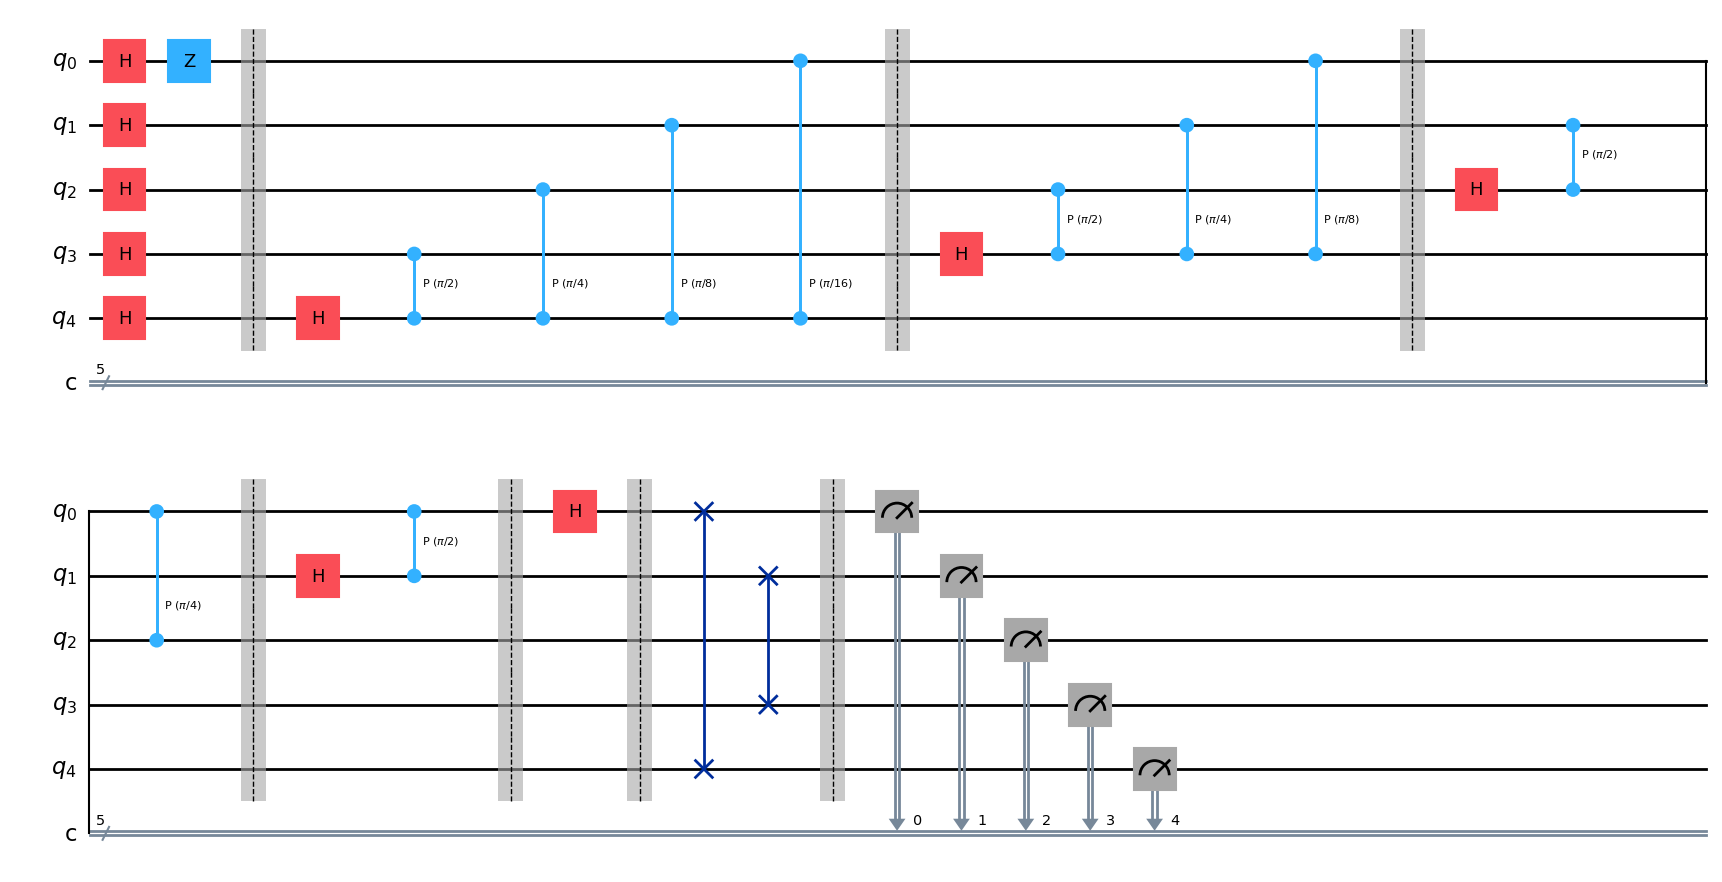

In [8]:
# Calling the function for creating QFT circuit
qft(qc, n_qubits)

# Creating the measurement of qubits
for i in range(n_qubits): 
    qc.measure(i,i)

# Visualizing the circuit
qc.draw(output='mpl', style='iqp')

**Fig 03 : 5 Qubit QFT Quantum Circuit with Z(0)**

The above circuit diagram comprises of following notations and components :

**Circuit Notations :**

- **qo, q1, q2, q3, q4** are the 5 qubits represented by the solid horizontal line.
- **c** is the classical bit after measurement which is represented by the double lines.
- **5/** above the double lines represents the no. of classical data bits measurements.

**Circuit Components :**

- **H** in orange boxes represents the Hadamard gate. 
- **Z** in sky-blue box represents the Z gate.
- **Controlled Phase Rotations** are represented by sky-blue lines.
- **Swap gates** are represented by dark-blue lines with cross.
- **Barrier** denoted by dotted lines separates the different segments of the circuit.
- **Meters** in gray boxes represents the Measurement operation on qubits.

#### iii) QFT Simulation :

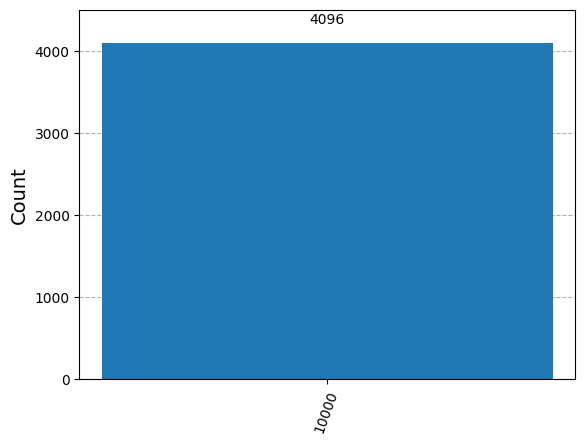

In [9]:
# Getting the simulator
simulator_qft = Aer.get_backend("qasm_simulator")

# Transpile transforms the circuit to something appropriate for the machine
sim_circuit_qft = transpile(qc, backend = simulator_qft)

# The run method in the simulator executes the transpiled circuit.
sim_job_qft = simulator.run(sim_circuit_qft, shots = 4096)

# I am fetching the results of the simulation job execution.
sim_result_qft = sim_job_qft.result()

# I am generating and displaying a histogram of the simulation outcomes.
plot_histogram(sim_result_qft.get_counts())

**Fig 04 : Measured state Vs Counts**

#### iv). Measured Frequency analysis

Expected QFT peak was ∣10000⟩

Measured QFT peak is also ∣10000⟩ with 100% probability after all 4096 trials.

**Hence, the measured frequency is in agreement with expected frequency.**

## Solution to (C) - IBM QC Hardware calculation

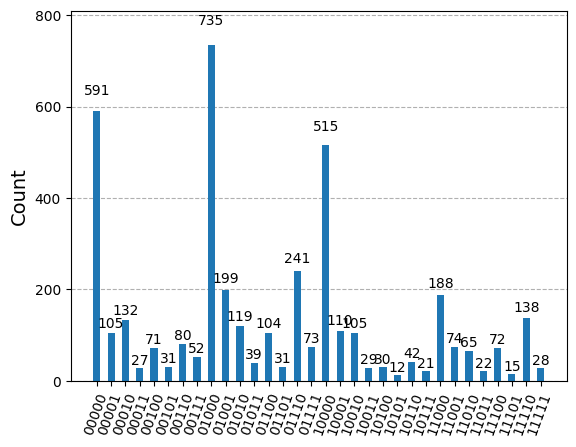

In [10]:
# Connecting with my IBMQ account and use the sevices
service = QiskitRuntimeService()

# Fetch list of all available quantum backends
mybackends = service.backends(operational = True, simulator = False, 
                              min_num_qubits = 5)

# Pick the best available backend
device = service.least_busy(operational = True, simulator = False, 
                            min_num_qubits = 5)

# Transforms my circuit to something appropriate for the hardware
transpiled_circuit = transpile(qc, device, seed_transpiler = 13)

# SamplerV2 is used to find the probabilities of output states
sampler = Sampler(mode = device)

# Executing the transpiled circuit
job_hardware = sampler.run([transpiled_circuit])

# Fetching the results of the sampler job execution.
result_hardware = job_hardware.result()

# the 1st element at 0th index is the public result
pub_result = result_hardware[0]

# Extracting the classical data from the public result
classical_data = pub_result.data.c

# Displaying a histogram of the execution outcomes
plot_histogram(classical_data.get_counts())

#### Hardware result analysis

The histogram represents the probability of measuring the output states when my quantum circuit runs on the IBM QC Hardware.

In the above histogram :
- The **x-axis** represents the measured states.
- The **y-axis** represents the number of times each state was measured.

The circuit ran for 4096 trials on the IBM QC Hardware. 

Here, on the x-axis, there are multiple different measured states with smaller counts.

**Hence, the hardware result is inconsistent due to noise.**